# One-dimensional packed-bed, catalytic-membrane reactor model without streamwise diffusion

The present model simulates heterogeneous catalytic processes inside packed-bed, catalytic membrane reactors. The gas-phase and surface-phase species conservation equations are derived and the system of differential-algebraic equations (DAE) is solved using the scikits.odes.dae IDA solver.

In [1]:
# Import Cantera and scikits
import numpy as np
from scikits.odes import dae
import cantera as ct
import matplotlib.pyplot as plt
%matplotlib inline
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.6.0a4


## Methodology

One-dimensional, steady-state catalytic-membrane reactor model with surface chemistry is developed to analyze species profiles along the length of a packed-bed, catalytic membrane reactor. The same model can further be simplified to simulate a simple packed-bed reactor by excluding the membrane. The example here demonstrates the one-dimensional reactor model explained by G. Kogekar, et al., "Efficient and robust computational models of  heterogeneous catalysis in catalytic membrane reactors," (2022), In preparation.

### Governing equations

Assuming steady, isothermal, one-dimensional flow within the packed bed, total-mass and species mass conservation may be stated as [1]

\begin{equation} 
\label{eq:mass_continuity_onepass}
\frac{{\rm d}(\rho u)}{{\rm d}z} = \sum_{k=1}^{K_{\text{g}}} \dot s_k W_k A_{\text{s}} + \frac{P_{\rm b}}{A_{\rm b}} \sum_{k=1}^{k_{\text{g}}} j_{k, {\rm M}},
\end{equation}
\begin{equation} 
\label{eq:species_continuity_onepass}
\rho u \frac{{\rm d}Y_k}{{\rm d}z} + A_{\text{s}} Y_k \sum_{k=1}^{K_{\text{g}}} \dot s_k W_k  =  A_{\rm s} \dot s_k W_k +  \frac{P_{\rm b}}{A_{\rm b}} j_{k, {\rm M}}.
\end{equation}

The fractional coverages of the $K_{\rm s}$ surface adsorbates $\theta_k$ must satisfy 
\begin{equation}
    \dot {s_k} = 0,     {\ \ \ \ \ \ } (k = 1,\ldots, K_{\rm s}),
    \label{eq:sdotzero}
\end{equation}
which, at steady state, requires no net production/consumption of surface species by the heterogeneous reactions.[2]

The independent variable in these conservation equations is the position $z$ along the reactor length.  The dependent variables include total mass flux $\rho u$, pressure $p$, temperature $T$, gas-phase mass fractions $Y_k$, and surfaces coverages $\theta_k$. Gas-phase fluxes through the membrane are represented as $j_{k, {\rm M}}$. Geometric parameters $A_{\rm s}$, $P_{\rm b}$, and $A_{\rm b}$ represent the catalyst specific surface area (i.e., surface area per unit volume), reactor perimeter, and reactor cross-sectional flow area, respectively. Other parameters include bed porosity $\phi_{\rm g}$ and gas-phase species molecular weights $W_k$. The gas density $\rho$ is evaluated using the equation of state (ideal Eos, RK or PR EoS).

The membrane flux is calculated using Sievert's law as
\begin{equation} \label{eq:membraneFlux}
j_{k_{\rm M}}^{\rm{Mem}} = \frac{B_{k_{\rm M}}}{t} \left ( p_{k_{\rm M}, {\rm{mem}}}^\alpha - p_{k_{\rm {M, sweep}}}^\alpha \right ) W_{k_{\rm M}}
\end{equation}
where $B_{k_{\rm M}}$ is the membrane permeability, $t$ is the membrane thickness. $p_{k_{\rm M}, {mem}}$ and $p_{k_{\rm {M, sweep}}}$ represent perm-selective species partial pressures within the packed-bed and the exterior sweep channel. The present model takes the pressure exponent $\alpha$ to be unity. The membrane flux for all other species ($ k \neq k_{\rm M}$) is zero.

### Chemistry mechanism
This example uses a detailed 12-step elementary micro-kinetic reaction mechanism that describes ammonia formation and decomposition kinetics over the Ru/Ba-YSZ catalyst. The reaction mechanism is developed and validated using measured performance in a laboratory-scale packed-bed reactor[3]. This example also incorporates a Pd-based H$_2$ perm-selective membrane.


### Solver

Above governing equations represent a complete solution for a steady-state packed-bed, catalytic membrane reactor model. The dependent variables are the mass-flux $\rho u$, species mass-fractions $Y_k$, pressure $p$, temperature $T$, and surface coverages $Z_k$. The equation of state is used to obtain the mass density, $\rho$.

The governing equations form an initial value problem (IVP) in a differential-algebraic (DAE) form as follows-
\begin{equation}
   f(z,{\bf{y}}, \bf {y'}, c) = 0,
\end{equation}
where $\bf{y}$ and $\bf{y'}$ represent the solution vector and its derivative vector, respectively. All other constants such as reference temperature, chemical constants, etc. are incorporated in vector $c$ (Refer [4] for more details). This type of DAE system in this example is solved using scikits.odes.dae IDA solver.

> 1. B. Kee, C. Karakaya, H. Zhu, S. DeCaluwe, and R.J. Kee, 'The Influence of Hydrogen-Permeable Membranes and Pressure on Methane Dehydroaromatization in Packed-Bed Catalytic Reactors', Industrial & Engineering Chemistry Research (2017) 56
> 2. R.J. Kee, M.E. Coltrin, P. Glarborg, and H. Zhu, 'Chemically Reacting Flow: Theory, Modeling and Simulation', Wiley (2018)
> 3. Z. Zhang, C. Karakaya, R.J. Kee, J. Douglas Way, C. Wolden,, 'Barium-Promoted Ruthenium Catalysts on Yittria-Stabilized Zirconia Supports for Ammonia Synthesis', ACS Sustainable Chemistry & Engineering (2019) 7:18038 – 18047
> 4. G. Kogekar, 'Computationally efficient and robust models of non-ideal thermodynamics, gas-phase kinetics and heterogeneous catalysis in chemical reactors' (2021), In preparation. 

### Define gas-phase and surface-phase species

In [2]:
# Import the reaction mechanism for Ammonia synthesis/decomposition on Ru-Ba/YSZ catalyst
mechfile = 'data/Ammonia-Ru-Ba-YSZ.yaml'
# Import the models for gas-phase
gas = ct.Solution(mechfile, 'gas');
# Import the model for surface-phase
surf = ct.Interface(mechfile, 'Ru_surface', [gas]);

# Other parameters
n_gas = gas.n_species               # number of gas species
n_surf = surf.n_species             # number of surface species
n_gas_reactions = gas.n_reactions   # Number of gas-phase reactions

# Set offsets
offset_rhou = 0
offset_p = 1
offset_T = 2
offset_Y = 3
offset_Z = offset_Y + n_gas
n_var = offset_Z + n_surf           # total number of variables (rhou, P, T, Yk and Zk)

print("Number of gas-phase species = ", n_gas)
print("Number of surface-phase species = ", n_surf)
print("Number of variables = ", n_var)

Number of gas-phase species =  4
Number of surface-phase species =  6
Number of variables =  13


### Define reactor geometry and operating conditions

In [3]:
# Reactor geometry
L = 5e-2                        # length of the reactor (m)
R = 5e-3                        # Radius of the reactor channel (m)
phi = 0.6                       # porosity of the bed (-)
tau = 2.0                       # toruosity of the bed (-)
dp = 3.37e-4                    # particle diameter (m)
As = 1e6                        # specific surface area (1/m)

# Membrane
mem_present = 1                 # Flag to include membrane (0 = no membrane, 1 = membrane)
mem_perm = 1e-15                # Membrane permeability (kmol*m3/s/Pa)
thickness = 3e-6                # Membrane thickness (m)
memsp_name = "H2"               # Membrane-permeable species name
p_sweep = 1e5                   # Partial pressure of permeable species in the sweep channel

if mem_present == 1:
    print("Modeling packed-bed, catalytic-membrane reactor...")    
    print(memsp_name, "permeable membrane is present.")    

# Get required properties based on the geometry and mechanism
W_g = gas.molecular_weights                              # vector of molecular weight of gas species
vol_ratio = phi/(1-phi)
eff_factor = phi/tau                                     # effective factor for permeability calculation
B_g = pow(vol_ratio, 2) * pow(dp, 2) * eff_factor / 72   # permeability based on Kozeny-Carman equation
area2vol = 2/R                                           # Area to volume ratio assuming a cylindrical reactor
memsp_ind = gas.species_index(memsp_name)                # Index of the membrane-permeable species

# Inlet operating conditions
T_in = 573                      # inlet temperature [K]             
p_in = 5e5                      # inlet pressure [Pa]
v_in = 0.001                    # inlet velocity [m/s]

# Set gas and surface states
gas.TPX = T_in, p_in, "NH3:1"   # Inlet composition
surf.TP = T_in, p_in
Yk_0 = gas.Y
rhou0 = gas.density * v_in

# Initial surface coverages
surf.advance_coverages(1e10)    # Advancing coverages over a long period of time to get the steady state.
Zk_0 = surf.coverages

Modeling packed-bed, catalytic-membrane reactor...
H2 permeable membrane is present.


### Define residual function required for IDA solver

In [4]:
def residual(z, y, yPrime, res):
    """ Solution vector for the model
        y = [rho*u, p, T, Yk, Zk]
        yPrime = [d(rho*u)dz, dpdz, dTdz, dYkdz, dZkdz]
    """
    # Get current thermodynamic state from solution vector and save it to local variables.
    rhou = y[offset_rhou]               # mass flux (density * velocity)
    Y = y[offset_Y:offset_Y + n_gas]    # vector of mass fractions of all gas species
    Z = y[offset_Z:offset_Z + n_surf]   # vector of site fractions of all surface species
    p = y[offset_p]                     # pressure
    T = y[offset_T]                     # temperature
    
    drhoudz = yPrime[offset_rhou]           # mass-flux spatial derivative
    dYdz = yPrime[offset_Y:offset_Y+n_gas]  # mass fraction spatial derivative
    dZdz = yPrime[offset_Z:offset_Z+n_surf] # site fraction spatial derivative
    dpdz = yPrime[offset_p]                 # pressure spatial derivative
    dTdz = yPrime[offset_T]                 # temperature spatial derivative
    
    # Set current thermodynamic state for the gas and surface phases
    # Note: use unnormalized mass fractions and site fractions to avoid over-constraining the system)
    gas.set_unnormalized_mass_fractions(Y)
    gas.TP = T,p
    surf.set_unnormalized_coverages(Z)
    surf.TP = T,p
    
    # Calculate required variables based on the current state
    coverages = surf.coverages                      # Surface site coverages
    sdot_g = surf.get_net_production_rates("gas")   # heterogeneous production rate of gas species
    sdot_s = surf.get_net_production_rates("Ru_surface")  # heterogeneous production rate of surface species
    wdot_g = np.zeros(n_gas)
    
    if n_gas_reactions > 0:
        wdot_g = gas.net_production_rates        # homogeneous production rate of gas species
    mu = gas.viscosity                           # viscosity of the gas-phase
    
    # Calculate flux term through the membrane
    permeance = mem_perm/thickness               # Permeance of the membrane (kmol*m2/s/Pa)
    memsp_pres = p*gas.X[memsp_ind]              # Partial pressure of membrane-permeable species        
    mem_flux = - permeance * (memsp_pres 
            - p_sweep) / W_g[memsp_ind]          # Negative sign indicates the flux going out

    # Conservation of total-mass 
    sum_continuity = As*np.sum(sdot_g*W_g) + phi*np.sum(wdot_g*W_g) # temporary variable
    res[offset_rhou] = drhoudz - sum_continuity - area2vol*mem_flux*mem_present 
    
    # Conservation of gas-phase species
    for k in range(n_gas):
        res[offset_Y+k] = dYdz[k] + (Y[k]*sum_continuity
                       - phi*wdot_g[k]*W_g[k] - As*sdot_g[k]*W_g[k])/rhou
        if k == memsp_ind:
            res[offset_Y+k] -= area2vol*mem_flux*mem_present
        
    # Conservation of site fractions (algebraic contraints in this example)
    for k in range(n_surf):
        res[offset_Z+k] = sdot_s[k]
        
    # For the species with largest site coverage, use the constraint sum(Zk) = 1
    ind_large = np.argmax(coverages)
    res[offset_Z+ind_large] = 1 - np.sum(coverages)
    
    # Conservation of momentum
    u = rhou/gas.density
    res[offset_p] = dpdz + phi*mu*u/B_g
    
    # Conservation of energy
    res[offset_T] = dTdz - 0
    
    # Calculate density using equation of state
    rho = gas.density
    u = rhou/rho

### Calculate the spatial derivatives at the inlet that will be used as the initial conditions for the IDA solver


In [5]:
# Initialize yPrime to 0 and call residual to get initial derivatives  
y0 = np.hstack((rhou0, p_in, T_in, Yk_0, Zk_0))
yprime0 = np.hstack(np.zeros(n_var))
res = np.hstack(np.zeros(n_var))
residual(0, y0, yprime0, res)
for n in range(n_var):
    yprime0[n] = -res[n]

### Solve the system of DAEs using ida solver

In [6]:
solver = dae(
    'ida',
    residual, 
    first_step_size=1e-15,
    atol=1e-18,  # absolute tolerance for solution
    rtol=1e-06,  # relative tolerance for solution
    algebraic_vars_idx=[np.arange(offset_Y+n_gas,offset_Z+n_surf,1)], 
    max_steps=8000,
    one_step_compute=True,
    old_api=False  # Forces use of new api (namedtuple)
)

time = []
solution = []
state = solver.init_step(0.0, y0, yprime0)

while state.values.t < L :
    time.append(state.values.t)
    solution.append(state.values.y)
    state = solver.step(L)
    
time = np.array(time)
solution = np.array(solution)
print(state)

SolverReturn(flag=<StatusEnumIDA.SUCCESS: 0>, values=SolverVariables(t=0.05258156606084604, y=array([2.13245131e-03, 4.99999349e+05, 5.73000000e+02, 3.67975151e-04,
       9.99870904e-01, 1.06174180e-04, 0.00000000e+00, 2.75635840e-05,
       9.99689590e-01, 2.69921166e-05, 2.24198743e-04, 2.25903380e-09,
       3.16534944e-05]), ydot=array([ 6.51127030e-03, -1.34780143e+01,  0.00000000e+00,  6.91097926e-03,
       -2.25113862e-03,  1.85142967e-03,  0.00000000e+00,  1.84563120e-05,
       -2.03900659e-04,  3.39947357e-05,  1.32125456e-04,  1.11395483e-09,
        1.93230387e-05])), errors=SolverVariables(t=None, y=None, ydot=None), roots=SolverVariables(t=None, y=None, ydot=None), tstop=SolverVariables(t=None, y=None, ydot=None), message='Successful function return.')


### Plot results

Text(0, 0.5, 'Site Fraction')

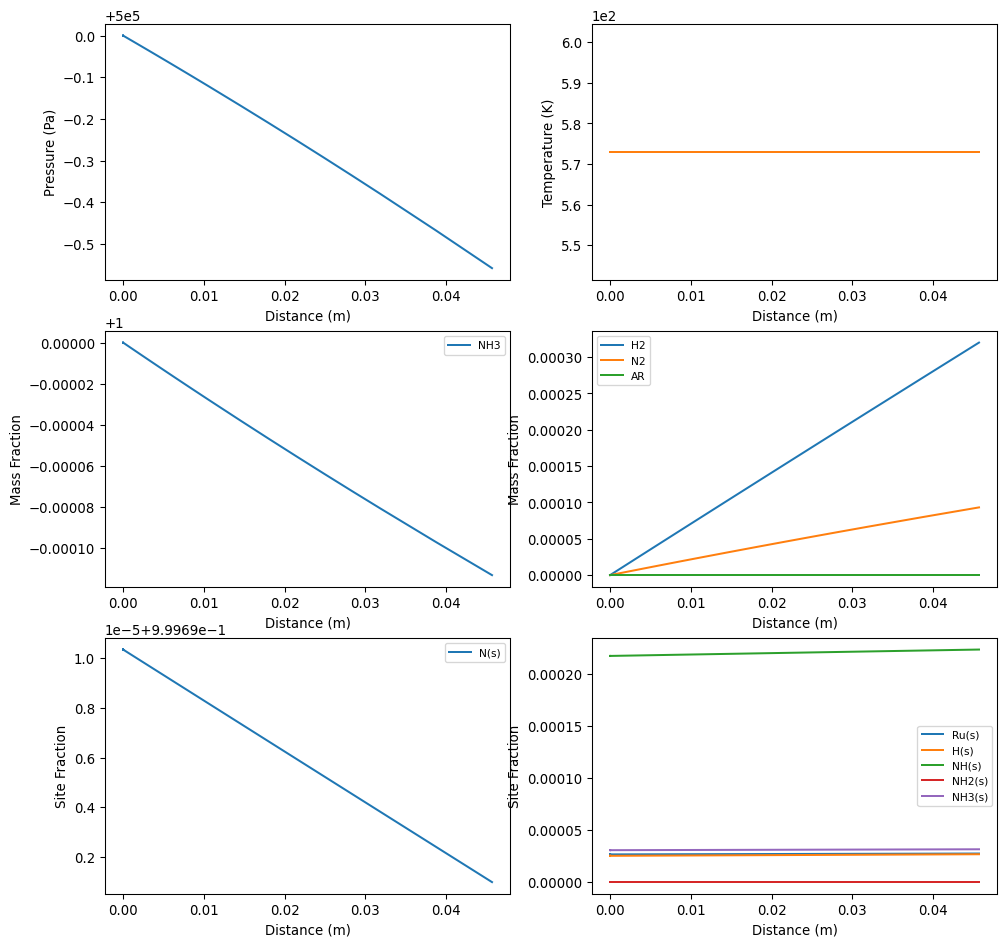

In [7]:
f, ax = plt.subplots(3,2, figsize=(12,12), dpi=96)

# plot gas pressure profile along the flow direction
ax[0,0].plot(time, solution[:,offset_p], color='C0')
ax[0,0].set_xlabel('Distance (m)')
ax[0,0].set_ylabel('Pressure (Pa)')

# plot gas temperature profile along the flow direction
ax[0,1].plot(time, solution[:,offset_T], color='C1')
ax[0,1].set_xlabel('Distance (m)')
ax[0,1].set_ylabel('Temperature (K)')
ax[0,1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2))  # scientific notation

# plot major and minor gas species separately
minor_idx = []
major_idx = []
for j,name in enumerate(gas.species_names): 
    mean = np.mean(solution[:,offset_Y+j])
    if mean <= 0.1:
        minor_idx.append(j) 
    else:
        major_idx.append(j)
        
# plot mass fractions of the gas-phase species along the flow direction

# Major gas-phase species
for j in major_idx:
    ax[1,0].plot(time, solution[:,offset_Y+j], label=gas.species_names[j])
ax[1,0].legend(fontsize=8, loc='best')
ax[1,0].set_xlabel('Distance (m)')
ax[1,0].set_ylabel('Mass Fraction')

# Minor gas-phase species
for j in minor_idx:
    ax[1,1].plot(time, solution[:,offset_Y+j], label=gas.species_names[j])
ax[1,1].legend(fontsize=8, loc='best')
ax[1,1].set_xlabel('Distance (m)')
ax[1,1].set_ylabel('Mass Fraction')

# plot major and minor surface species separately
minor_idx = []
major_idx = []
for j,name in enumerate(surf.species_names): 
    mean = np.mean(solution[:,offset_Z+j])
    if mean <= 0.1:
        minor_idx.append(j) 
    else:
        major_idx.append(j)

# plot the site fraction of the surface-phase species along the flow direction
# Major surf-phase species
for j in major_idx:
    ax[2,0].plot(time, solution[:,offset_Z+j], label=surf.species_names[j])
ax[2,0].legend(fontsize=8, loc='best')
ax[2,0].set_xlabel('Distance (m)')
ax[2,0].set_ylabel('Site Fraction')

# Minor surf-phase species
for j in minor_idx:
    ax[2,1].plot(time, solution[:,offset_Z+j], label=surf.species_names[j])
ax[2,1].legend(fontsize=8, loc='best')
ax[2,1].set_xlabel('Distance (m)')
ax[2,1].set_ylabel('Site Fraction')